# CFL condition for finite-difference simulations (3-point): fault-zone trapped waves
_Computational Seismology, Igel (2016)_ <br>
Exercise 4.30

_Determine numerically the stability limit of 1D and 2D implementations of the acoustic wave equation as accurately as possible by varying the stability criterion._

Acoustic wave equation (inhomogeneous):
$$\partial_t^2 p(x,t) - c^2 \Delta p(x,t) = s(x,t)$$

We can calculate a solution by iterating over the time elements:
$$p(t+dt) \approx 2p(t) - p(t-dt) + dt^2[c^2\partial^2_xp + s].$$

We'll use a 3-point operator for the second derivative in $x$:
$$d^2_xp(x) \approx \frac{p(x+dx) - 2p(x) + p(x-dx)}{dx^2}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("error", category=RuntimeWarning)   # convert this warning to an error (this will be used to escape the dx2p loop)

### 1D

In [2]:
xmax = 500         # spatial range (km)
dx = .5            # distance between grid points
nx = int(xmax/dx)  # number of grid points
tmax = 1.5         # length of seismogram
c = 343            # wavefield velocity
ixsrc = 100        # x-coord. of source
ixrec = 200        # x-coord. of receiver

x = np.linspace(-nx*dx/2, nx*dx/2, nx)    # space

# some stf parameters
f0 = 20    # dominant frequency (Hz)
t0 = .2    # time shift
A  = 1


Overflow at index 80 of derivative calculation 
epsilon = 1.1


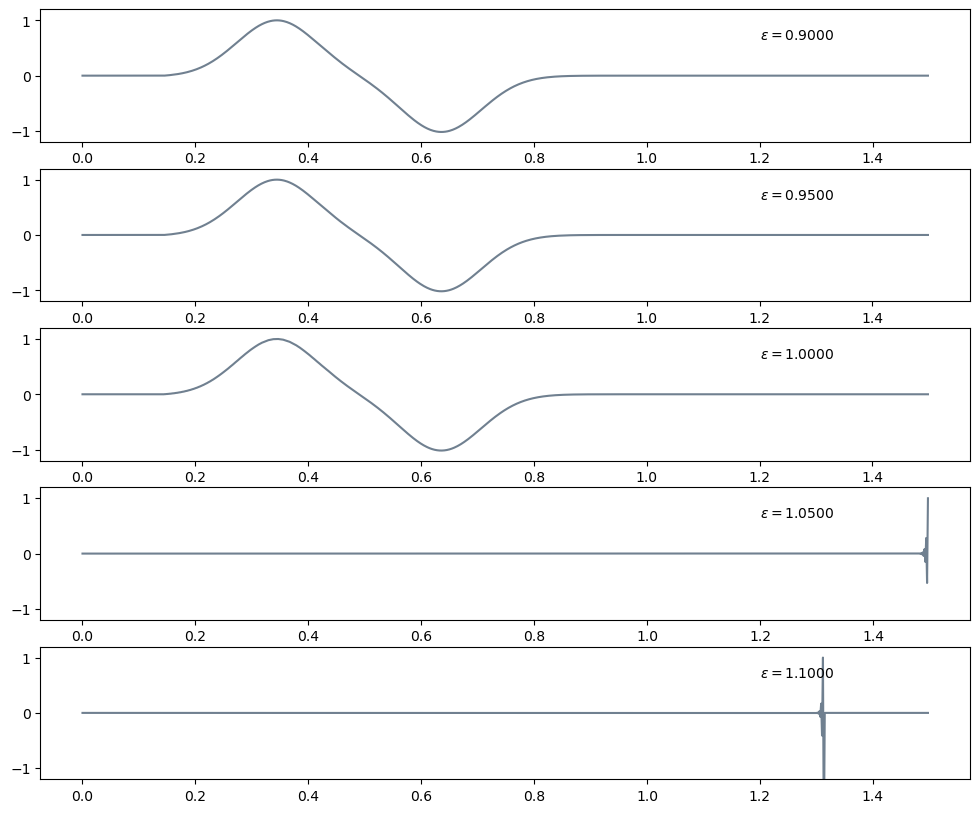

In [3]:
eps = np.arange(.9, 1.1, .05)    # stability limits to test

quit = False
fig, axs = plt.subplots(len(eps), 1, figsize = (12, 2*len(eps)))


# iterate over each epsilon
for i in range(len(eps)):
    dt = eps[i]*dx/c               # time interval (depends on epsilon)
    nt = int(tmax/dt)              # number of time steps
    t = np.arange(0, nt*dt, dt)    # time
    p    = np.zeros(nx) 
    pold = np.zeros(nx) 
    pnew = np.zeros(nx) 
    dx2p = np.zeros(nx)
    seis = np.zeros(nt)

    # source time function
    src = -A*f0*(t-t0)*np.exp(-((t - t0)*f0 / (2*A))**2)
    
    for it in range(nt):

        # calculate partial derivatives
        for ix in range(1, nx - 1):
            try:
                dx2p[ix] = (p[ix + 1] - 2 * p[ix] + p[ix - 1]) / dx**2

            # skip the calculation if dx2p explodes
            except RuntimeWarning as e:
                quit = True
                break
        
        if quit == False:
            # time extrapolation
            pnew = 2 * p - pold + c ** 2 * dt ** 2 * dx2p
        
            # add source term at ixsrc      
            pnew[ixsrc] = pnew[ixsrc] + dt**2 * src[it] / dx
            
            # remap time levels
            pold = p
            p = pnew
        
            # make seismogram
            seis[it] = p[ixrec]

        # end loop if dx2p exploded 
        else:
            print('Overflow at index', ix, 'of derivative calculation \nepsilon =', eps[i])
            break
    
    # plot seismogram
    axs[i].plot(t[:nt], seis/max(seis), 'slategray')
    axs[i].set_ylim((-1.2, 1.2))
    axs[i].text(1.2, .65, '$\\epsilon = {:.4f}$'.format(eps[i]))

### 2D

In [4]:
xmax = 10           # spatial range (km)
zmax = 10
dx = .1125          # distance between grid points (km)
dz = dx
nx = int(xmax/dx)   # number of grid points
nz = int(zmax/dz)
    
tmax = 3.5          # length of seismogram (s)
#dt = .0026          # time interval
#nt = int(tmax/dt)   # number of time steps
    
w  = .2             # fault zone width
xsrc = 0 - w/2      # x-coord. of source (on left edge of fault zone)
zsrc = 0            # z-coord. of source
xrec = 3.5          # x-coord. of receiver
zrec = 3.5          # z-coord. of source
f0 = 10             # dominant frequency (Hz)
t0 = .3             # time shift
c = 3               # velocity
x = np.arange(-xmax/2, xmax/2, dx)      # space
z = np.arange(-zmax/2, zmax/2, dz)
# t = np.arange(0, tmax-dt, dt)           # time

# get indices of source & receiver locations (will be used to add source term/make seis in algorithm)
ixsrc, ixrec = round(((xsrc+xmax/2)/xmax)*len(x)), round(((xrec+xmax/2)/xmax)*len(x))
izsrc, izrec = round(((zsrc+zmax/2)/zmax)*len(z)), round(((zrec+zmax/2)/zmax)*len(z))


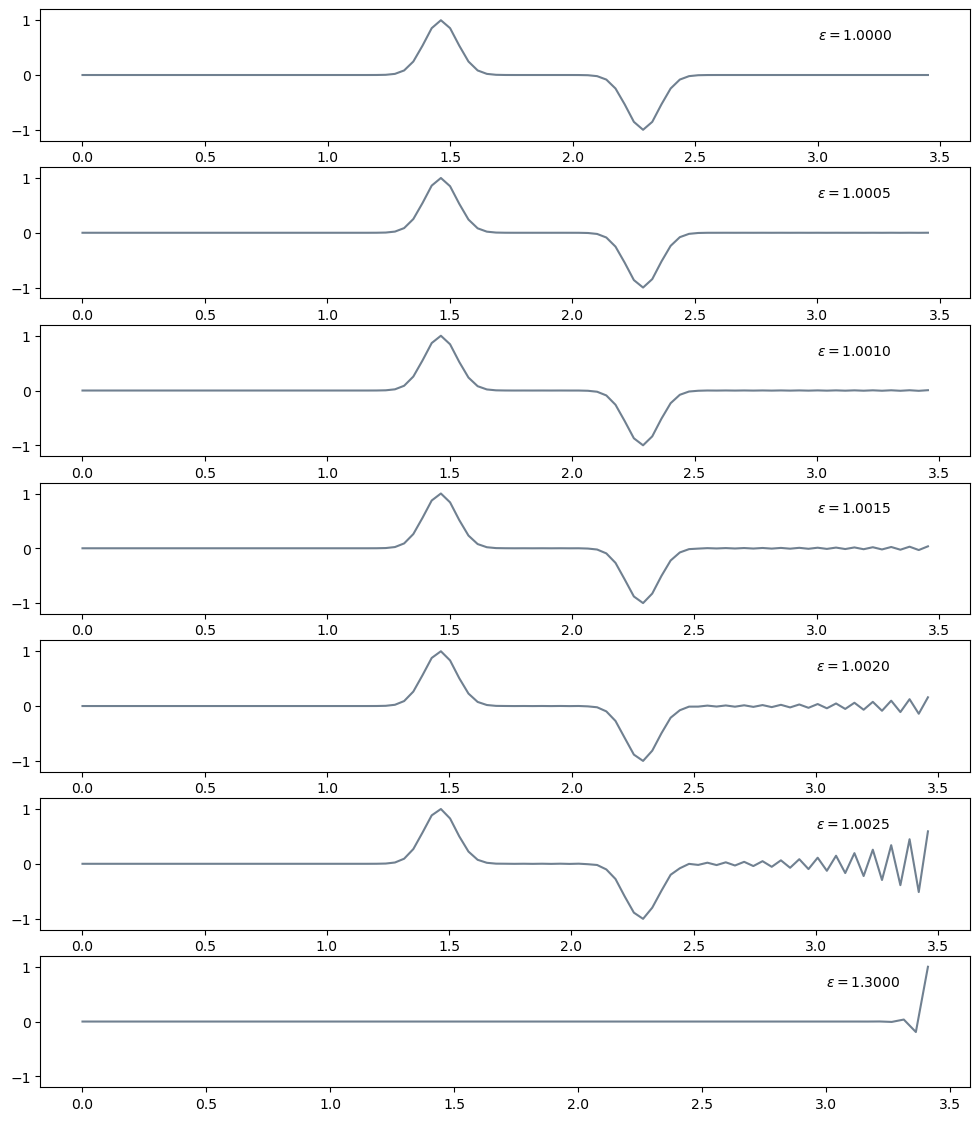

In [5]:
# eps = np.arange(.9999, 1.0005, .00005)    # stability limits to test
eps = np.arange(1.000, 1.003, .0005)    # stability limits to test
eps = np.append(eps, 1.3)

quit = False
fig, axs = plt.subplots(len(eps), 1, figsize = (12, 2*len(eps)))


# iterate over each epsilon
for i in range(len(eps)):
    dt = eps[i]*dx/c               # time interval (depends on epsilon)
    nt = int(tmax/dt)              # number of time steps
    t = np.arange(0, nt*dt, dt)    # time
    p = np.zeros((nx, nz), dtype = np.float64) 
    pold = np.zeros((nx, nz), dtype = np.float64)   # p(t-dt)
    pnew = np.zeros((nx, nz), dtype = np.float64)   # p(d+dt)
    dx2p = np.zeros((nx, nz), dtype = np.float64)   # 2nd derivative in space
    dz2p = np.zeros((nx, nz), dtype = np.float64)   # 2nd derivative in space
    seis = np.zeros(nt)

    # source time function
    src = -8*f0*(t-t0)*np.exp(  -((t - t0)*f0)**2   )
    
    for it in range(nt):

        # calculate partial derivatives
        for ix in range(1, nx - 1):
            try:
                dx2p[ix, :] = (p[ix + 1, :] - 2 * p[ix, :] + p[ix - 1, :]) / dx**2

            # skip the calculation if dx2p explodes
            except RuntimeWarning as e:
                quit = True
                break

        if quit == False:

            for iz in range(1, nz - 1):
                try:
                    dz2p[:, iz] = (p[:, iz + 1] - 2 * p[:, iz] + p[:, iz - 1]) / dz**2
    
                # skip the calculation if dz2p explodes
                except RuntimeWarning as e:
                    quit = True
                    break
        else:
            print('Overflow at x index', ix, 'of derivative calculation \nepsilon =', eps[i])
            break
            
        if quit == False:    
            # time extrapolation
            pnew = 2 * p - pold + c ** 2 * dt ** 2 * dx2p
        
            # add source term at ixsrc      
            pnew[ixsrc] = pnew[ixsrc] + dt**2 * src[it] / dx
            
            # remap time levels
            pold = p
            p = pnew
        
            # make seismogram
            seis[it] = p[ixrec, izrec]

        # end loop if dx2p exploded 
        elif quit == True:
            print('Overflow at z index', iz, 'of derivative calculation \nepsilon =', eps[i])
            break
    
    # plot seismogram
    axs[i].plot(t[:nt], seis/max(seis), 'slategray')
    axs[i].set_ylim((-1.2, 1.2))
    axs[i].text(3, .65, '$\\epsilon = {:.4f}$'.format(eps[i]))
